In [1]:
import sys

import torch_geometric.transforms

sys.path.append('../')

import random
from incidence_graph import IncidenceGraph
import multignn
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch_geometric.datasets as datasets

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

device = torch.device(f'cuda:5' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'Available memory: {torch.cuda.get_device_properties(device).total_memory / 1024 ** 3 - torch.cuda.memory_allocated(device) / 1024 ** 3:.2f} GB')

Using device: cuda:5
Available memory: 15.75 GB


In [2]:
DATA = datasets.Planetoid(name='Cora', root='cora_data')[0]
G = IncidenceGraph()
for edge in DATA.edge_index.T:
    G.put_simplex((edge[0].item(), edge[1].item()))
X = DATA.x.to(device=device)
Y = DATA.y
CATS = max(Y) + 1
V = G.size(0)

print(f'Graph shape: {G.shape()}')
print(f'Categories: {CATS}')

Graph shape: [2708, 5278]
Categories: 7


In [3]:
MAX_DIST = 3
Ds = [i for i in G.degree_lists(neighbor_dists=range(MAX_DIST + 1), rel_dims=[], node_list=range(V), pow=-1, add=1)[0].values()]
edge_list = torch.as_tensor([list(range(V)), list(range(V))])
As = G.sparse_matrices(neighbor_dists=range(MAX_DIST+1), rel_dims=[], dims=[0])
for i in range(1, MAX_DIST+1):
    diag = torch.sparse_coo_tensor(edge_list, Ds[i], size=(V, V)).coalesce()
    As[i] = torch.sparse.mm(diag, As[i] + As[0]).to(device=device)

In [19]:
# run to change GPU
for i in range(1, MAX_DIST+1):
    As[i] = As[i].to(device=device)
X = X.to(device=device)

In [4]:
def train(SEED, A_SIZE, D, EPOCHS, LOGGING, LAYERS=1):
    random.seed(SEED)
    torch.random.manual_seed(SEED)

    A = As[1:A_SIZE+1]
    layers = []
    for i in range(LAYERS):
        in_shape = X.shape[1] if i == 0 else D
        output_func = nn.Sequential(nn.Linear(D, CATS), nn.LogSoftmax(dim=1)) if i == LAYERS - 1 else nn.Linear(D, D)
        layers.append(multignn.MultiGraphLayer(vertex_agg_func=multignn.sparse_vertex_agg,
                                               update_func= multignn.LinearMessageUpdate(in_shape, in_shape, D, activation_func=nn.ReLU(), use_bias=True),
                                               output_func=output_func))
    model = multignn.PartialForwardNN(*layers).to(device=device)
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_func = nn.NLLLoss()
    #sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

    tr_losses = []
    val_losses = []

    it = range(EPOCHS)
    if LOGGING == 0:
        it = tqdm(it, desc='Training')
    elif LOGGING == 1:
        print('Epoch #: Train Loss, Validation Loss, Validation Accuracy')

    for epoch in it:
        opt.zero_grad()
        output = model.forward(X, A).to(device='cpu')
        loss = loss_func(output[DATA.train_mask], Y[DATA.train_mask])
        loss.backward()
        opt.step()
        tr_losses.append(loss.item())

        with torch.no_grad():
            output = model.forward(X, A)[DATA.val_mask].to(device='cpu')
            val_loss = loss_func(output, Y[DATA.val_mask])
            val_losses.append(val_loss.item())
            pred = torch.argmax(output, dim=1)
            val_acc = (pred == Y[DATA.val_mask]).sum().item() / len(pred)
            #sched.step(val_loss)

        if LOGGING == 1:
            print(f'Epoch {epoch + 1:4}\t{loss.item():.8f}\t{val_loss.item():.8f}\t{val_acc:.3f}')

    if LOGGING == 0:
        it.close()

    return model, tr_losses, val_losses

In [5]:
def plot(tr_losses, val_losses, start=0, filename=None):
    xs = list(range(start, len(tr_losses)))
    plt.rcParams['figure.figsize'] = (9.0, 6.0)
    plt.plot(xs, tr_losses[start:], label='training loss')
    plt.plot(xs, val_losses[start:], label='validation loss')
    #plt.yscale('log', base=16)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss values from epochs {start + 1} to {len(tr_losses)}')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [6]:
def test(model, A_SIZE):
    A = As[1:A_SIZE+1]
    model.eval()
    output = model.forward(X, A).to(device='cpu')
    pred = output[DATA.test_mask].argmax(dim=1)
    acc = (pred == Y[DATA.test_mask]).sum().item() / len(pred)
    return acc

Epoch #: Train Loss, Validation Loss, Validation Accuracy
Epoch    1	1.94789565	1.89588273	0.564	0.577
Epoch    2	1.79723954	1.84044933	0.714	0.737
Epoch    3	1.65291715	1.78603351	0.740	0.769
Epoch    4	1.51470685	1.73231089	0.752	0.779
Epoch    5	1.38251448	1.67902696	0.760	0.788
Epoch    6	1.25635505	1.62603223	0.768	0.791
Epoch    7	1.13630867	1.57325411	0.770	0.794
Epoch    8	1.02253067	1.52071202	0.770	0.799
Epoch    9	0.91521180	1.46851325	0.768	0.799
Epoch   10	0.81458533	1.41682553	0.764	0.801
Epoch   11	0.72087830	1.36588514	0.764	0.801
Epoch   12	0.63429481	1.31596375	0.762	0.801
Epoch   13	0.55498916	1.26736450	0.762	0.803
Epoch   14	0.48300454	1.22039056	0.762	0.802
Epoch   15	0.41826522	1.17532301	0.762	0.802
Epoch   16	0.36058277	1.13242972	0.766	0.805
Epoch   17	0.30964240	1.09193051	0.766	0.804
Epoch   18	0.26503339	1.05399156	0.770	0.805
Epoch   19	0.22626868	1.01871967	0.768	0.805
Epoch   20	0.19282553	0.98616648	0.774	0.804
Epoch   21	0.16414887	0.95632225	0.774	0.8

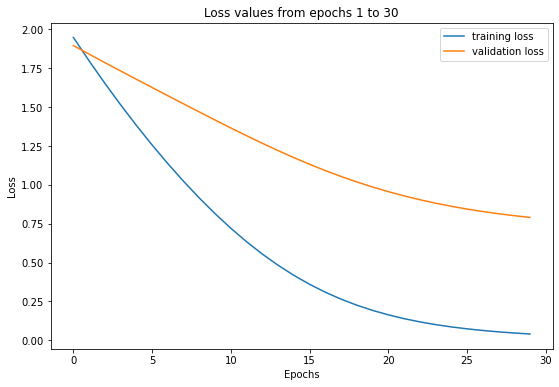

Test accuracy: 80.40


In [39]:
# 8192 30/35(3)
# 32768 20/25/30(2), 10/15/20(3)
# 65536 10/15/20(2,3)
A_SIZE = 2
model, tr_losses, val_losses = train(12312, A_SIZE, 32768, 30, 1)
plot(tr_losses, val_losses)
print(f'Test accuracy: {test(model, A_SIZE) * 100:.2f}')

In [12]:
A_SIZE=3
results = []
for seed in tqdm(range(100)):
    model, _, _ = train(seed, A_SIZE, 65536, 20, -1)
    results.append(test(model, A_SIZE))
print(f'MEAN: {torch.mean(torch.tensor(results)).item() * 100:.2f}')
print(f'MED: {torch.median(torch.tensor(results)).item() * 100:.2f}')
print(f'STDDEV: {torch.std(torch.tensor(results)).item() * 100:.2f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [17:15<00:00, 10.35s/it]

MEAN: 80.58
MED: 80.60
STDDEV: 0.19


In [ ]:
"""
best: ASIZE=2 epochs=15 D=65536  80.92 0.28
    ASIZE=3 epochs=15 D=65536 80.92 0.20
"""